# Predicting Bitcoins' Closing Price using historical data
# A Time Series Analysis

## IMBA 2020 - Data Analytics for Managers

### Group 1:
             - Cristina Carrion
             - Frederico Andrade
             - Jorge Lozano
             - Maresa Vaitl

### 1. Introduction

Cryptocurrencies, such as Bitcoin, have suddenly become strong rivals to traditional currencies around the world.
These digital currencies are available for purchase anywhere in the world, and have gradually been accepted as exchange currency within many retailers, which makes us believe that money (as we have traditionally known it) might eventually undergo a tremendous change in the upcoming years.

Hereinafter, and during the International MBA at IE University - Madrid -, our group intends to explore this topic through the approach of Forecasting Time Series on Bitcoin Closing price prediction, as part of our final group project for the "Data Analytics for Managers" Course. Even though we have performed a regression model using Excel, we intend to build a model that we could use to compare with the previous excel analysis in order to determine which approach has better accuracy.

The objective of this notebook is to explore the cryptocurrency market of Bitcoin throughout 2014 and 2018, while building a Time Series Forecasting. 
The model should be able to predict the closing values of Bitcoin for the next months (after the last registered date in our data).
As such, we want to verify how well this model will perform its prediction, and if it is possible to compute such a model as a good evaluator of Bitcoin within the cryptocurrencies's stock market.




### 1.1. Importing the necessary python libraries , vital for our upcoming analysis

In [23]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error 
from pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 })


Computing the date in the standard model (YY-MM-DD), and loading the data.

In [24]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('crypto-markets.csv', parse_dates=['date'], index_col='date', date_parser=dateparse)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [25]:
df.sample(5) ## A sample of 5 rows within our dataset

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2018-08-07,ark,ARK,Ark,83,0.865201,0.912893,0.839743,0.840992,487292.0,87762992.0,0.0171,0.07
2018-03-29,acchain,ACC,ACChain,2029,0.558929,0.592393,0.468772,0.482815,577.0,0.0,0.1136,0.12
2017-10-03,ronpaulcoin,RPC,RonPaulCoin,1603,0.071960,0.073846,0.047606,0.048003,37.0,42064.0,0.0151,0.03
2017-08-07,golos,GOLOS,Golos,769,0.120755,0.131845,0.116120,0.131227,28775.0,16340241.0,0.9607,0.02
2014-03-12,namecoin,NMC,Namecoin,371,3.380000,3.480000,3.370000,3.430000,192821.0,28252001.0,0.5455,0.11


Even though we were able to find a complete dataset with a great variety of different cryptocurrencies, we decided to focus only on Bitcoin in order to simplify and have a more precise analysis. Therefore, the code below will simply display Bitcoin and drop the remaining data.

In [26]:
btc=df[df['symbol']=='BTC']

In [27]:
btc.drop(['volume', 'market'],axis=1,inplace=True)

### 2. Monthly Forecasting

### 2.1. Stationary check (Seasonality)

After cleaning our dataset to excluaively display Bitcoin, we proceeded to use a Stationarity Test in our data. 
Stationarity means that the statistical properties of the process of generating a time series will not change over time. This does not mean that the actual series will not change, but rather the way it changes won't affect the model's learning curve, making the series easier to analyze.

As such, we are going to proceed with the Dickey-Fuller test, as shows below:

In [28]:
## Changing the frequency to monthly data:

Bitcoin_monthly = btc.resample('M').mean()

Dickey–Fuller test: p=0.479017


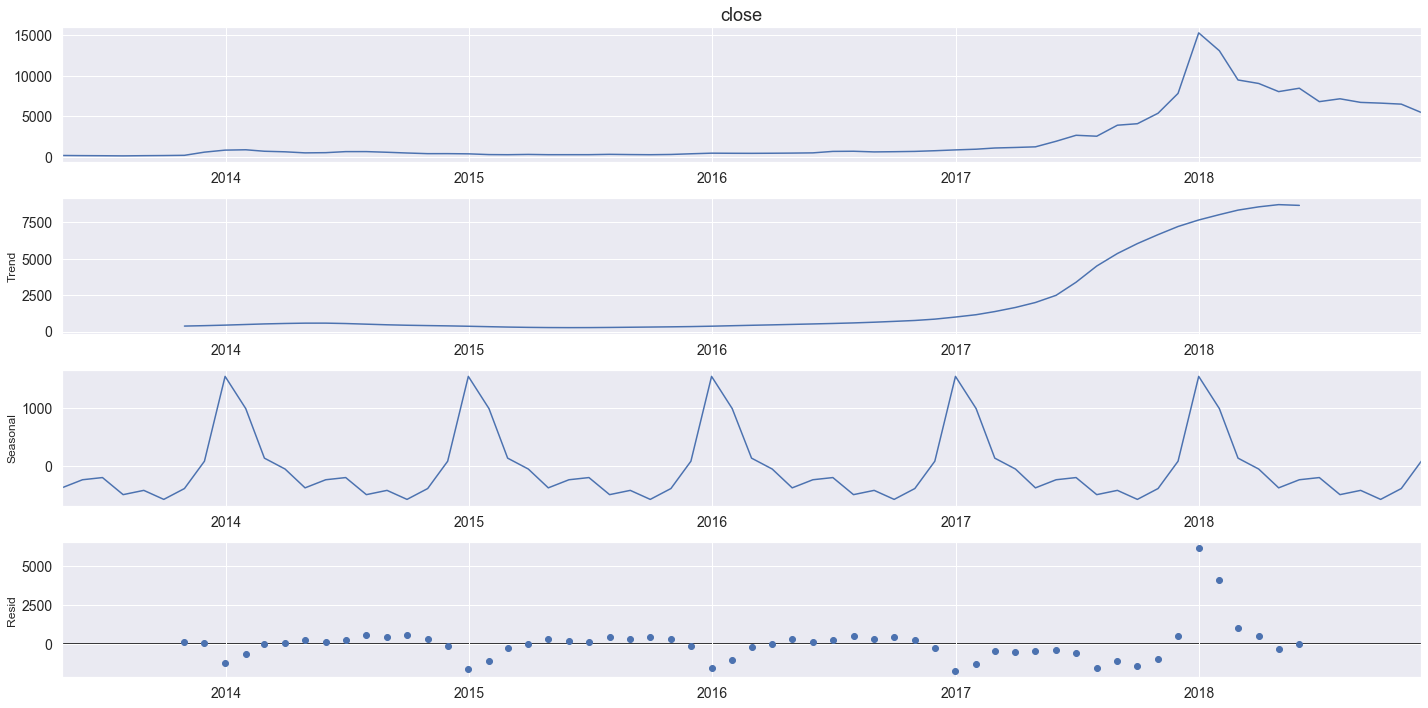

In [29]:
## Dickey-Fuller:

seasonal_decompose(Bitcoin_monthly.close, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(Bitcoin_monthly.close)[1])

The p-value indicates that this series is not stationary, with 47,90% confidence.
Nevertheless, we can find a seasonal component that denotes the same behavior on a yearly basis (which is curious as there should not be seasonality in the Cryptocurrency stock market).

Additionally, and attending to the residuals, we can see a constant behavior until the start of 2018.
Since the price around this time is experiencing high volatility, the forecasting might not be as accurate as we expect.

This said, even though our series is not stationary, we will try to suppress the variance throughout different transformations.

Firstly, we will compute a Box-Cox Transformation. If this doesn't work, we will have to compute Differencing in a second attempt.

### 2.2. Box-Cox Transformation

Box-cox is often used to modify the distributional shape of the data in order to be normally distributed. It makes the variance of the error constant (making it easier to validade).

However, even after applying the transformation, the series may not appear stationary.

In [90]:
Bitcoin_monthly['close_box'], lmbda = stats.boxcox(Bitcoin_monthly.close)
print("Dickey–Fuller test: p=%f" % adfuller(Bitcoin_monthly.close_box)[1])

Dickey–Fuller test: p=0.479048


According to the p-value, the series is still not stationary

### 2.3. Differencing

Since the series is not stationary yet, we should proceed to differencing the data to make it more stationary: calculating the difference between "xt" and "xt-1".

In this sense, we will compute the difference between an observation and the corresponding observation of the previous year.

### 2.3.1. Seasonal Differencing

In [92]:
# Seasonal differentiation (12 months)
Bitcoin_monthly['box_diff_seasonal_12'] = Bitcoin_monthly.close_box - Bitcoin_monthly.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(Bitcoin_monthly.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.055750


Because the p-value is still >0,05 (non-stationarity), a second difference must be taken into account to finally transform the data into a stationary. This will help us in the predictions (if it's not stationary we won't have an accurate prediction).

### 2.3.2. Regular Differencing

Dickey–Fuller test: p=0.025730


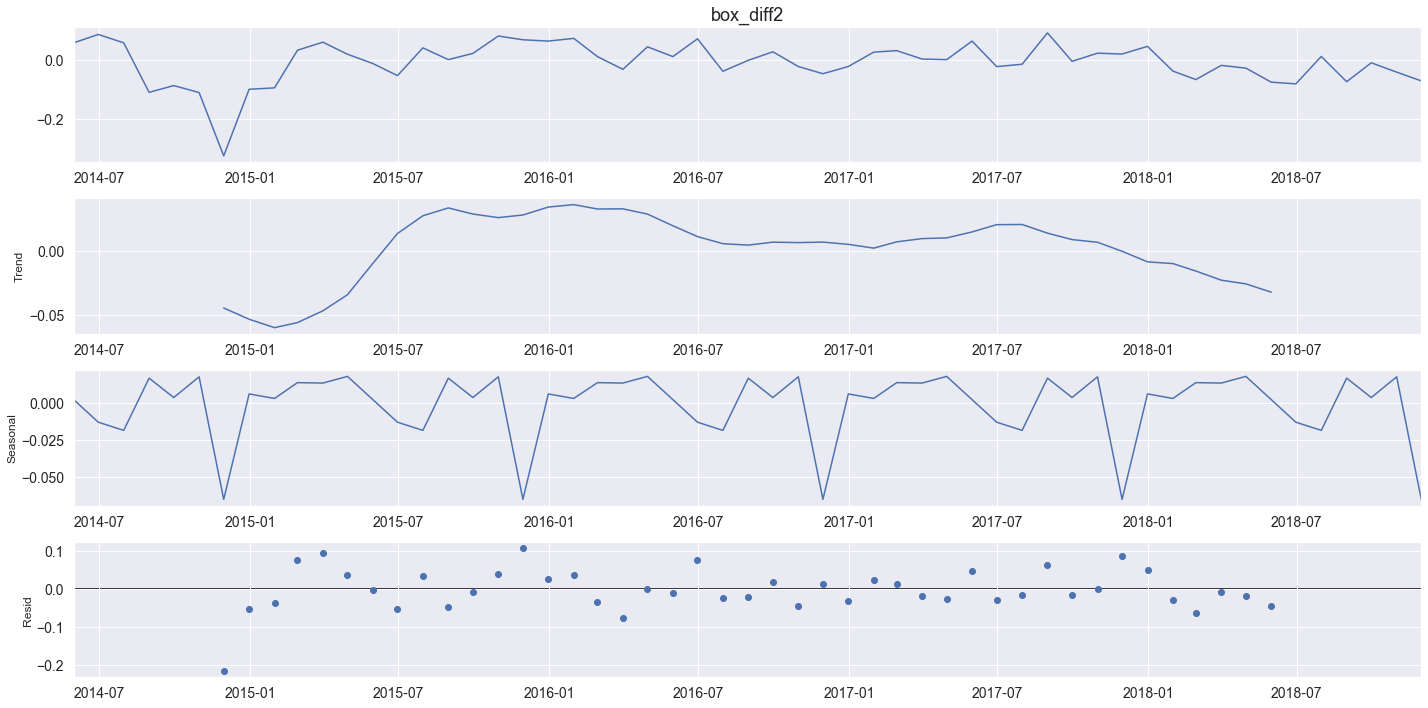

In [94]:
Bitcoin_monthly['box_diff2'] = Bitcoin_monthly.box_diff_seasonal_12 - Bitcoin_monthly.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(Bitcoin_monthly.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(Bitcoin_monthly.box_diff2[13:])[1])

The p-value now indicates the series is stationary, and our points are independent of one another (<0,05)

### 2.4. Autocorrelation

Autocorrelation is a type of serial dependence between data points (bitcoin prices). Simply put it, it checks for significance in the data points: if the lags (lines) are outside the blue shade, it means they are significant (therefore, shouldn't be considered). The other way around, if they are within the max or min of the AR concavity - blue shade -, they should be taken into account for our prediction.

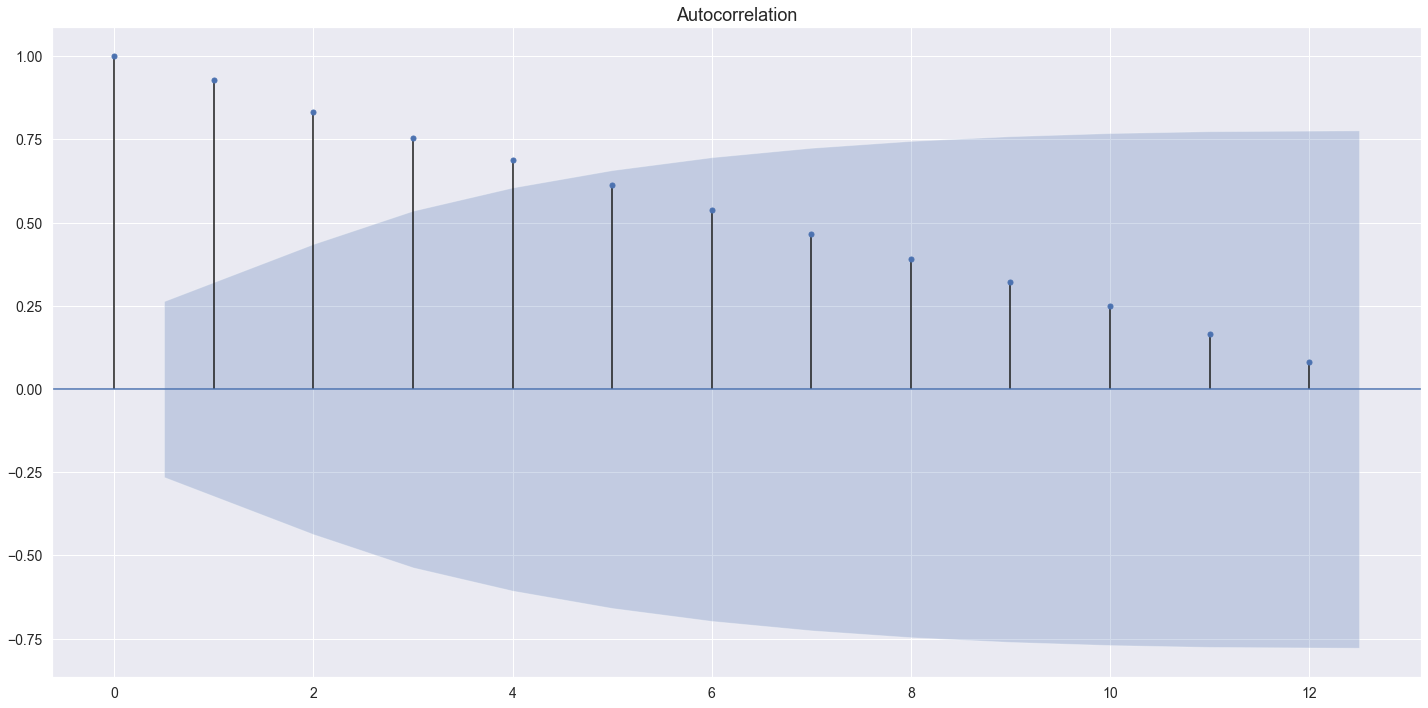

In [41]:
#autocorrelation_plot(btc_month.close)
plot_acf(Bitcoin_monthly.close[13:].values.squeeze(), lags=12)
plt.tight_layout()

In our case, we can observe a spike on the 3rd lag, which will be taken into account for our model later on (since the 3rd lag might still be in accordance to the max of AR)

Now let's try autocorrelation on the differences since we have more than two lags in the graph above (ACF and PACF)

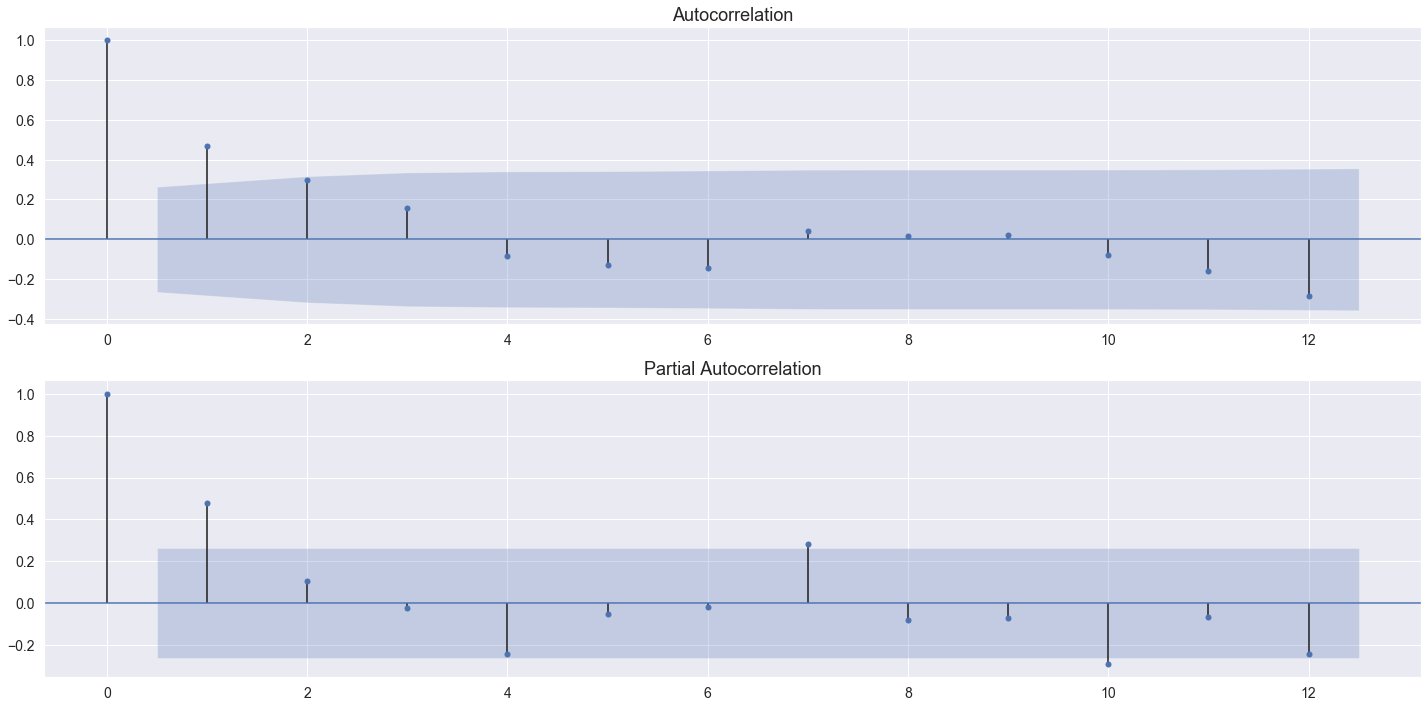

In [101]:
 #Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(Bitcoin_monthly.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_pacf(Bitcoin_monthly.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()

There is only one spike outside the insignificant zone, and due to that, there might not be enough information available to build a good ARIMA model later on. Looking at the PACF, we can notice that we have lags of quarters (3 months).

### 2.5. SARIMA Model
Seasonal Autoregressive Integrated Moving Average

SARIMA model has 3 parameters (p,d,q) accounting for seasonality, trend and noise in the dataset:

p - the number of lag observations to include in the model, or lag order. (AR)

d - the number of times that the raw observations are differenced, or the degree of differencing. (I)

q - the size of the moving average window, also called the order of moving average.(MA)

### 2.5.1. Parameter Selection

We will use the SARIMAX model to explore different combinations for (p,d,q).

Therefore, we will consider AIC to determine how well the model fits the data (the lower AIC the better).

In [97]:
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(Bitcoin_monthly.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [98]:
results

[[(0, 0), -195.64564374846393],
 [(0, 1), -203.17257655388912],
 [(0, 2), -201.51134211147868],
 [(1, 0), -203.74131675922692],
 [(1, 1), -201.77930783324243],
 [(1, 2), -199.82045148878288],
 [(2, 0), -201.7724003605861],
 [(2, 1), -200.2974703924864],
 [(2, 2), -198.28168215117037]]

For some reason we can't understand, the test is not recognizing any bad parameters. Let's proceed and test the best model combination:

In [99]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
3     (1, 0) -203.741317
1     (0, 1) -203.172577
4     (1, 1) -201.779308
6     (2, 0) -201.772400
2     (0, 2) -201.511342


In [100]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   68
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 103.871
Date:                Thu, 05 Nov 2020   AIC                           -203.741
Time:                        00:51:32   BIC                           -199.332
Sample:                    04-30-2013   HQIC                          -201.997
                         - 11-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3750      0.149      2.524      0.012       0.084       0.666
sigma2         0.0026      0.000     12.206      0.000       0.002       0.003
Ljung-Box (Q):                       20.67   Jarque-

In this output, we can notice that the AIC is lowest for the (1,1,0). Moreover, looking at the output P>|z| we can see that our features are significant (=0,012).

### 2.5.2. Final Prediction

In [72]:
# Reverse Box-Cox Transformation Function
def revboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Text(0, 0.5, 'USD')

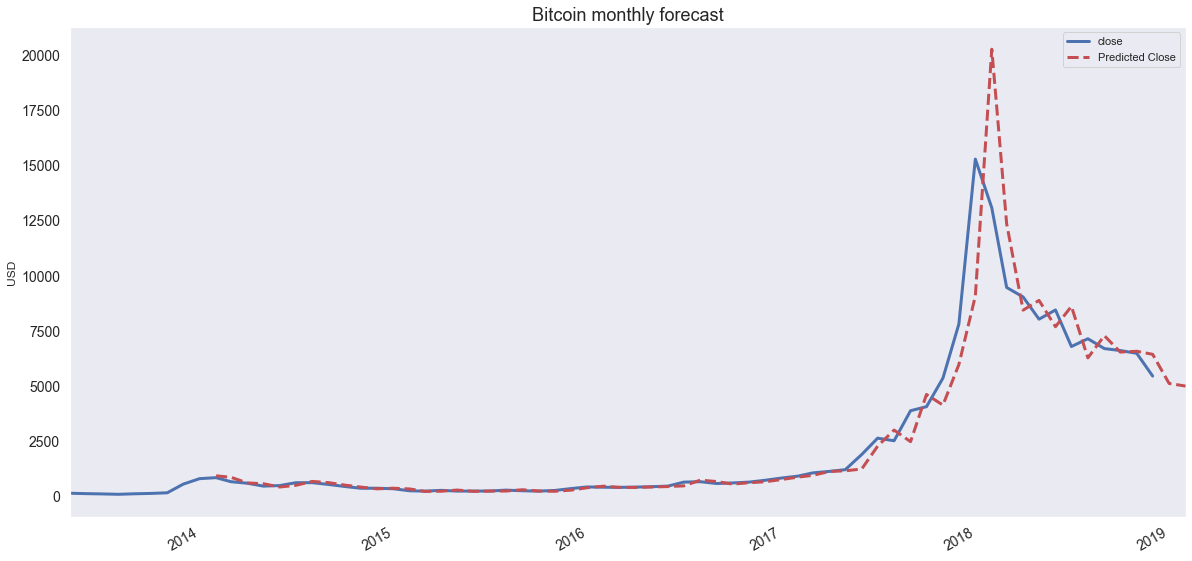

In [89]:
# Prediction
Bitcoin_monthly_pred = Bitcoin_monthly[['close']]
date_list = [datetime(2018, 11, 30), datetime(2018, 12, 31), datetime(2019, 1, 31)]
future = pd.DataFrame(index=date_list, columns= Bitcoin_monthly.columns)
Bitcoin_monthly_pred = pd.concat([Bitcoin_monthly_pred, future])

#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
Bitcoin_monthly_pred['forecast'] = revboxcox(best_model.predict(start=datetime(2014, 1, 31), end=datetime(2019, 1, 31)), lmbda)

Bitcoin_monthly_pred.close.plot(linewidth=3)
Bitcoin_monthly_pred.forecast.plot(color='r', ls='--', label='Predicted Close', linewidth=3)
plt.legend()
plt.grid()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')

### 2.6. Conclusion

According to our model, we can see that the predictions are in line with the actual closing values of Bitcoin. The model is predicting the behavior of Bitcoin 3 months ahead (November + December 2018 and Jan 2019 - given that we have data until Nov. 2018). In this sense, we can see some discrepancies between the model and the real data during 2018, but with a similar behaviour. In 2019 the closing price of Bitcoin will continue in a downward trend, which is possibly due to the valuation of other cryptocurrencies on the rise (such as Etherium). 

In the begginning of 2018 we can verify that there is a sudden upwards spike, which is related to the high valuation of Bitcoin and the resurgence of the Cryptocurrency's trade market. Even though the model is able to understand this behaviour, we can see that it is still not 100% accurate (and this is something very hard to achieve, as we are dealing with a high price volatility market). 

Therefore, this model should not be taken as trading advice, mostly due to the high price volatily in the cryptocurrency trade market.

P.S. We have tried building a SARIMAX model with the (P, D, Q, p, d, q) components. However, after analyzing the RMSE, we concluded that the SARIMA would perform better for our analysis. Hence, we have decided not to include the SARIMAX in our analysis.